<a href="https://colab.research.google.com/github/teoad95/Sport-analytics/blob/main/Football_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Football analytics using AI techniques</h1>
<p> </p>

**Given**
* A video stream of a football match recorded by a single broadcast-like camera

**Extract**
* as much information as possible


## Introduction

Develop an AI solution for sport analytics (football), which will:

- Detect players
  - on single frame
  - splitted window frame
- Classify players per team
  - using machine learning techniques
- Detect player's number in jersey (not done)
  - used pre-trained yolo model in SVHN dataset
- Image mapping into 2D football court (not done)
  - Generate dataset with frame - homography map
    - Generate database of homography maps, by zooming, tilting, etc.
  - Train GAN network to generate edge map images given frame input
  - Using HOG descriptor, find the best matching homography maps of database to the generated one
  - Plot image in 2D football court.

In [1]:
import cv2
import torch
import pandas as pd
import numpy as np
import time
import os
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline

In [4]:
!git clone https://github.com/teoad95/Sport-analytics/

Cloning into 'Sport-analytics'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 221 (delta 75), reused 35 (delta 14), pack-reused 91
Receiving objects: 100% (221/221), 133.94 MiB | 29.79 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [5]:
os.rename('/content/Sport-analytics', 'SportAnalytics')

In [ ]:
pip install pytube

##1 Generate dataset
For dataset generation (frame pictures) we created a function which given a youtube link, downloads the video and split it into frames every 0.5 sec.

In [8]:
from SportAnalytics.util_funs import get_frames_from_youtube_video
get_frames_from_youtube_video('https://www.youtube.com/watch?v=TeTQO5DgOXI')

Downloaded /content/Videos/Highlights Real Madrid vs FC Barcelona (2-1).mp4, in location Videos correctly!


In [42]:
image_location = '/content/SportAnalytics/Images/frame53.jpg'

##2 Detect players
For this task,  we used a pretrained [YOLOv5s](https://github.com/ultralytics/yolov5) model (PyTorch)

* 7.3M parameters
* inference size 320 pixels
* average single frame inference time 0.07s

In [ ]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [32]:
img = cv2.imread(image_location, cv2.IMREAD_COLOR)

In [13]:
def plot_image(image,title = '', figsize_to_set = (10,30)):
  %matplotlib inline
  from matplotlib import pyplot as plt
  plt.figure(figsize=figsize_to_set)
  plt.imshow(image[:,:,::-1])
  plt.title(title)
  plt.axis('off')
  plt.show()

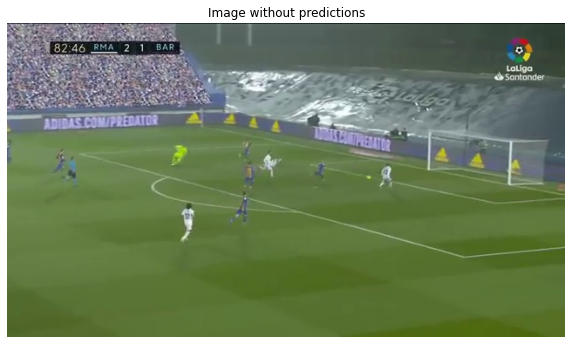

In [33]:
plot_image(img, 'Image without predictions')

Now, using yolov5 we will detect all persons in the image.

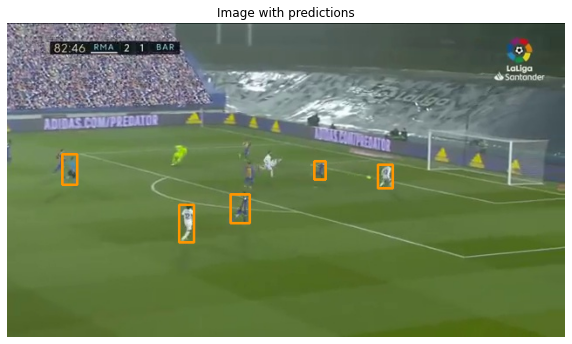

--- 0.49 seconds ---


In [36]:
from SportAnalytics.util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.5, show_text=False)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plot_image(cv2_img_bb, 'Image with predictions')

print("--- %.2f seconds ---" % (time.time() - start_time))

In [43]:
img = Image.open(image_location)

--- 2.50 seconds ---


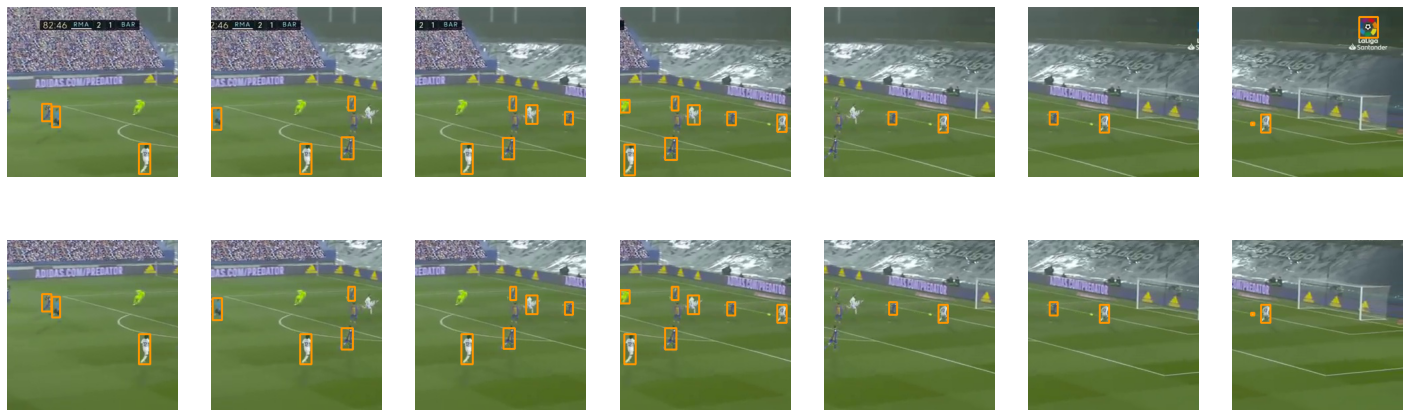

In [45]:
from SportAnalytics.util_funs import plot_bb_on_img, split_image_and_predict, sliding_window, keep_unique_objects_df
import math


fig = plt.figure(figsize=(25, 25))

img_width, img_height = img.size


step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
 
    # inference
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
    img = np.array(img) 
    #Convert RGB to BGR 
    img = img[:, :, ::-1].copy() 


    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes, show_text=False)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.IMREAD_COLOR)
    # plt.title(box)
    plt.imshow(cv2_img_bb )
    plt.axis('off')
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
boxes_df = keep_unique_objects_df(boxes_df, epsilon=0.5)
          
print("--- %.2f seconds ---" % (time.time() - start_time))

Inference on **frame partitions**, using a **sliding window**

Merge predictions by using
* the bounding box center point
* a distance threshold to identify unique objects

Average Prediction Time: **0.5s**



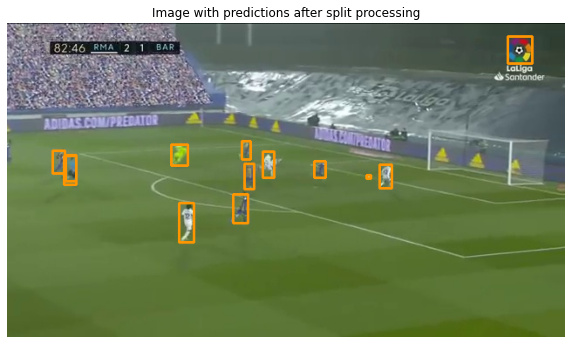

--- 2.38 seconds ---


In [50]:
from SportAnalytics.util_funs import plot_bb_on_img, split_image_and_predict
import matplotlib.pyplot as plt

img = cv2.imread(image_location, cv2.IMREAD_COLOR)
start_time = time.time()
boxes =  split_image_and_predict(img, model,epsilon=1)

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3, show_text=False)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plot_image(cv2_img_bb, 'Image with predictions after split processing')
print("--- %.2f seconds ---" % (time.time() - start_time))

##3 Detect players and extract player object using RCNN

Used a pretrained [Mask RCNN](https://github.com/stephanj/basketballVideoAnalysis/tree/master/mask-rcnn) on COCO dataset

* great results
* come with a cost | inference time (avg) : 4 sec 


In [51]:
image_location2 = '/content/SportAnalytics/Images/frame24.jpg'

In [52]:
RED_COLOR = np.array([255, 0, 0]) 
BLACK_COLOR = np.array([255, 255, 255]) 

<p>Load weights and Mask-RCNN configuration</p>

In [53]:
weightsPath = "/content/SportAnalytics/network_configuration/frozen_inference_graph.pb"
configPath = "/content/SportAnalytics/network_configuration/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] image size: 640x360 pixels


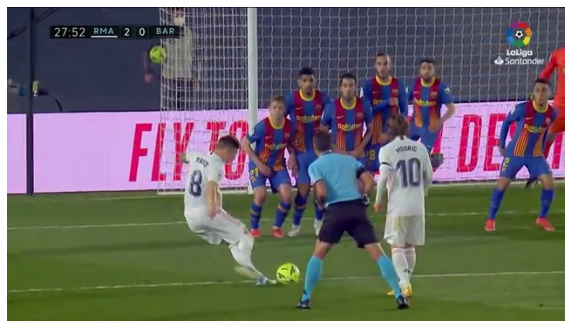

In [54]:
# load our input image and grab its spatial dimensions
image = cv2.imread(image_location2, cv2.IMREAD_UNCHANGED)
(H, W) = image.shape[:2]
print("[INFO] image size: {}x{} pixels".format(W, H))
plot_image(image)

In [55]:
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] boxes size: {}".format(boxes.size))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 6.942191 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] boxes size: 700
[INFO] masks shape: (100, 90, 15, 15)


(-0.5, 639.5, 359.5, -0.5)

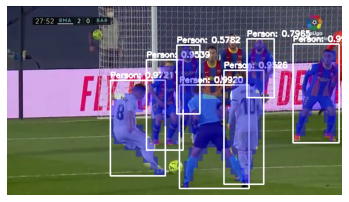

In [56]:
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):

	# extract the class ID of the detection along with the confidence
	# (i.e., probability) associated with the prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

	# filter out weak predictions by ensuring the detected probability
	# is greater than the minimum probability
	if confidence > 0.5:
		# clone our original image so we can draw on it
		# clone = image.copy()

		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the height
		# of the bounding box
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

		# extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions of the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH), interpolation = cv2.INTER_NEAREST)
		mask = (mask > 0.3)

		# extract the ROI of the image
		roi = image[startY:endY, startX:endX]
			
		# now, extract *only* the masked region of the ROI by passing in the boolean mask array as our slice condition
		roi = roi[mask]

		# Red will be used to visualize this particular instance segmentation 
		# then create a transparent overlay by blending the randomly selected color with the ROI
		blended = ((0.4 * RED_COLOR) + (0.6 * roi)).astype("uint8")

		# store the blended ROI in the original image
		image[startY:endY, startX:endX][mask] = blended

		# draw the bounding box of the instance on the image
		cv2.rectangle(image, (startX, startY), (endX, endY), (255,255,255), 2)

		# draw the predicted label and associated probability of the instance segmentation on the image
		text = "{}: {:.4f}".format("Person", confidence)
		cv2.putText(image, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

plt.imshow(image[:,:,::-1])
plt.axis('off')

In [57]:
players = []

In [58]:
def extract_players(image):
    start = time.time()
    height, width , _ = image.shape
    cv2_img_bb = np.array(image) 
    # Convert RGB to BGR 
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB) 
    for i in range(boxes.shape[2]):
        box = boxes[0, 0 ,i]
        class_id = box[1]
        score = box[2]
        if (score < 0.5):
            continue
        # get box coordinates
        x = int(box[3] * width)
        y = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)

        object_of_image = image[y: y2, x: x2]
        ooi_height, ooi_width, _ = object_of_image.shape

        # get the mask
        mask = masks[i, int(class_id)]
        mask = cv2.resize(mask, (ooi_width, ooi_height))
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

        # convert mask to proper type in order to perform the bitwise_and
        visMask = (mask * 255).astype("uint8")

        # extract from box only the object for classification
        final = cv2.bitwise_and(object_of_image, object_of_image, mask = visMask)
        players.append(final)
        cv2.rectangle(cv2_img_bb, (x,y), (x2,y2), (255, 0, 0), 3)
        print("--- %.2f seconds ---" % (time.time() - start_time))

In [59]:
extract_players(cv2.imread(image_location2))

--- 407.39 seconds ---
--- 407.39 seconds ---
--- 407.39 seconds ---
--- 407.39 seconds ---
--- 407.39 seconds ---
--- 407.39 seconds ---
--- 407.39 seconds ---


(-0.5, 51.5, 111.5, -0.5)

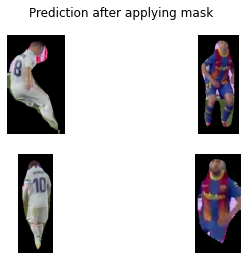

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Prediction after applying mask')
ax1.imshow(players[2][:,:,::-1])
ax1.axis('off')
ax2.imshow(players[3][:,:,::-1])
ax2.axis('off')
ax3.imshow(players[4][:,:,::-1])
ax3.axis('off')
ax4.imshow(players[5][:,:,::-1])
ax4.axis('off')

##4 Classify players per team

The typical way to classify different players objects is by color.
For this task, kmeans with 2 clusters used.
We found the average of the colors of each player's image and then we will cluster them in 2 centers.

In [78]:
image_location3 = '/content/SportAnalytics/Images/frame35.jpg'

In [79]:
cv2_img = cv2.imread(image_location3)

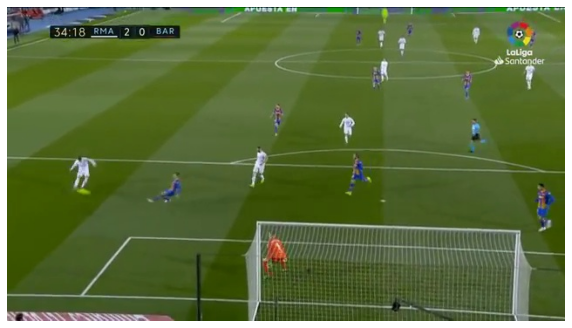

In [63]:
plot_image(cv2_img)

In [ ]:
boxes =  split_image_and_predict(cv2_img, model)
# plot bounding boxes
cv2_img_bb = plot_bb_on_img(cv2_img, boxes, tolerance=0.3, show_text=False)

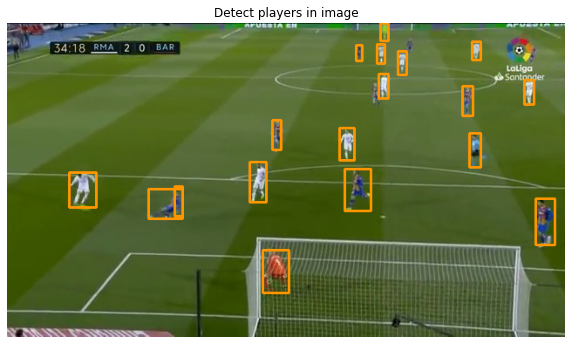

In [67]:
plot_image(cv2_img_bb[:,:,::-1], 'Detect players in image')

**Segmentation using HSV Color Space**

Image Segmentation using HSV Color Space
* identifying green pixels in a particular range 
* use identified pixels as a mask for the field
* apply mask and get players

**Good Results, but trouble extracting features**



--- 0.01 seconds ---


(-0.5, 639.5, 359.5, -0.5)

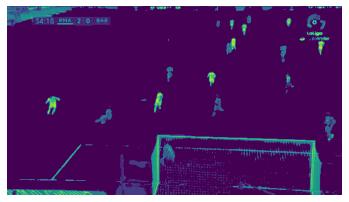

In [82]:
original_image = cv2_img  
inputIm = original_image[..., ::-1]

start_time = time.time()
hsv = cv2.cvtColor(inputIm,cv2.COLOR_BGR2HSV)
#green range
lower_green = np.array([25, 52, 72])
upper_green = np.array([102, 255, 255])
#Define a mask ranging from lower to uppper
mask = cv2.inRange(hsv, lower_green, upper_green)
mask = 255-mask
#Do masking
res = cv2.bitwise_and(inputIm, inputIm, mask=mask)
#convert to hsv to gray
res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2RGB)
res_gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
print("--- %.2f seconds ---" % (time.time() - start_time))
plt.imshow(res_gray )
plt.axis('off')

**Average Color of Image**

In [68]:
def extract_average_color(img):
    # calculate the average color of each row of our image
    avg_color_per_row = np.average(img, axis=0)

    # calculate the averages of our rows
    avg_colors = np.average(avg_color_per_row, axis=0)
    # so, convert that array to integers
    int_averages = np.array(avg_colors, dtype=np.uint8)
    return int_averages

In [69]:
players = []

In [70]:
original_image = cv2.imread(image_location3)
boxes.assign(Name='image')
for i, b in boxes.iterrows():
    players.append(original_image[int(b['ymin']):int(b['ymax']), int(b['xmin']):int(b['xmax'])])
boxes['image'] = players

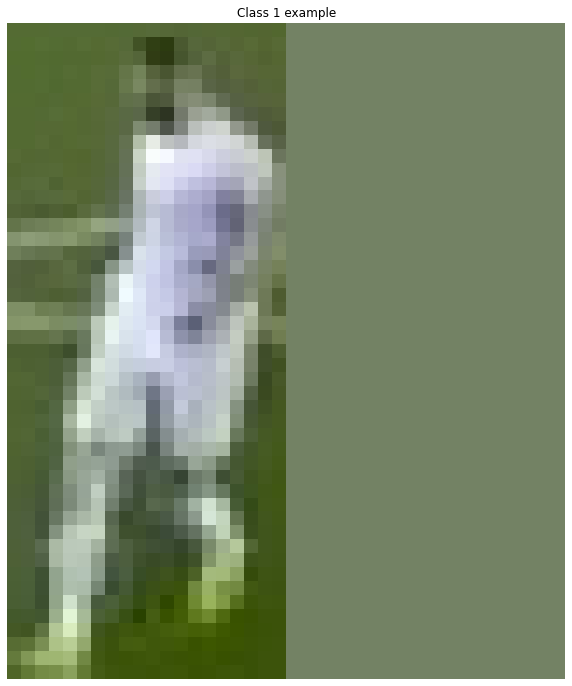

In [71]:
height, width, _ = np.shape(boxes['image'][2])
int_averages = extract_average_color(boxes['image'][2])
average_image = np.zeros((height, width, 3), np.uint8)
average_image[:] = int_averages
plot_image(np.hstack([boxes['image'][2], average_image]), 'Class 1 example')

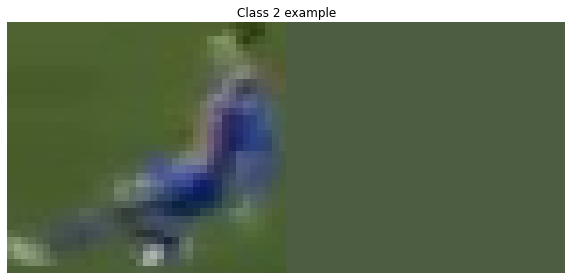

In [72]:
height, width, _ = np.shape(boxes['image'][0])
int_averages = extract_average_color(boxes['image'][0])
average_image = np.zeros((height, width, 3), np.uint8)
average_image[:] = int_averages
plot_image(np.hstack([boxes['image'][0], average_image]), 'Class 2 example')

In [73]:
from sklearn.cluster import KMeans

In [74]:
features = [extract_average_color(b.image) for i,b in boxes.iterrows()]
clusters = KMeans(2, random_state= 40)
clustering_results = clusters.fit_predict(features)
boxes['team'] = clustering_results

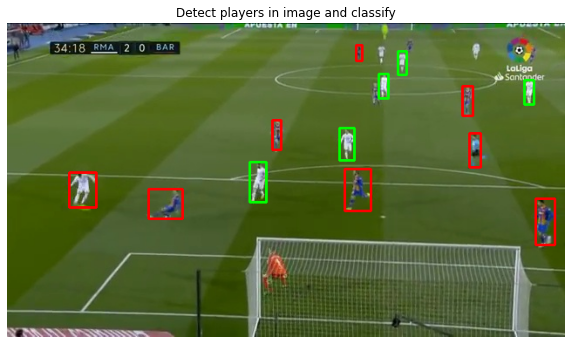

In [76]:
from SportAnalytics.util_funs import plot_bb_on_img_with_teams

cv2_img_bb = plot_bb_on_img_with_teams(original_image, boxes, show_text=False)
plot_image(cv2_img_bb[:,:,::-1], 'Detect players in image and classify')

##5 Detect player number
For this experiments we used an already trained and configured yolo network on SVHN dataset. Unfortunatelly the network did not generalize well and we couldnt extract any information from the images. For more information check Detect_numbers.ipynb.

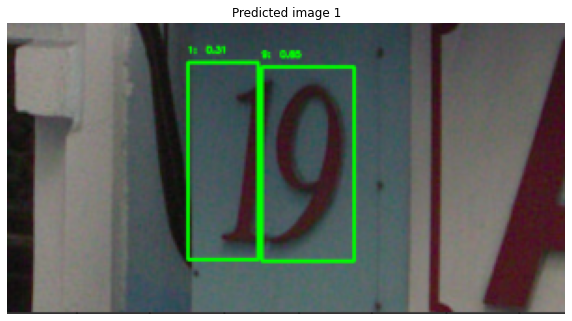

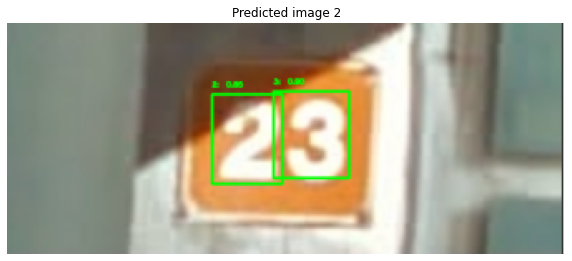

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/DetectNumberPred1.png'), 'Predicted image 1')
plot_image(cv2.imread('/content/SportAnalytics/Images/DetectNumberPred2.png'), 'Predicted image 2')

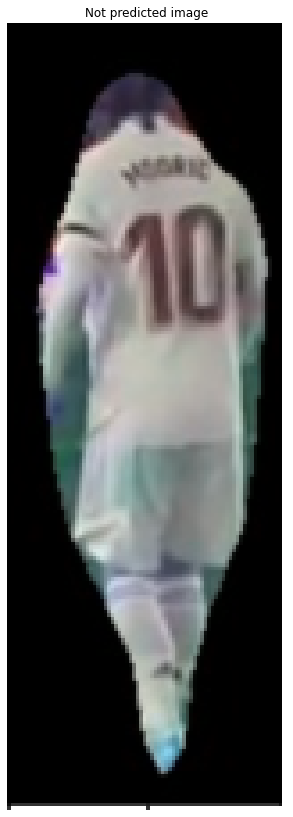

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/DetectNumberNotPred.png'), 'Not predicted image', (5,15))

##6 Image mapping into 2D football court

For this task we used, [Automatic Birds Eye View Registration of Sports Videos](https://nihal111.github.io/hawk_eye/) help. Our goal was to transform and plot a game image into a 2D court. The dataset we used is the World Cup dataset collected by http://www.cs.toronto.edu/~namdar/pdfs/sports_cvpr_2017.pdf. The dataset consists of frames of 20 different soccer matches played during the 2014 World Cup. The 210 frames in the training dataset and 200 frames in the test dataset, each having a homography matrix, is used to map the camera view into the top view [1]. Each image is associated we a part of the 2D court which represent the 'place' in the court. In order to train the GAN we had to generate a dataset of two folders, "TrainA" and "TrainB". In trainA folder placed all the real images and in TrainB the 2D associated images. The GAN will learn to get a real image from a football game and return us a 2D image of the place of the court.


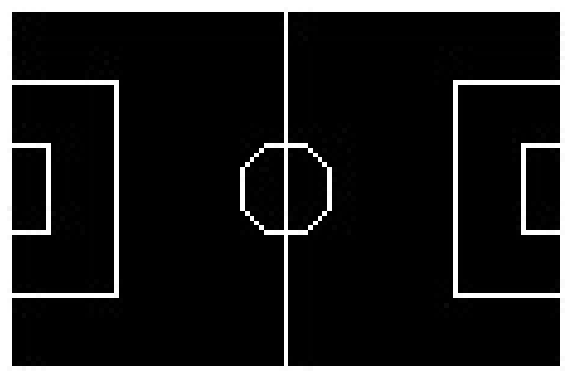

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/football_field.jpg'))

For dataset generation we just excecuted a loop over all train images.

In [ ]:
import numpy as np
import cv2
from matplotlib import path
import matplotlib.pyplot as plt
from perturb_functions.pan import pan
from perturb_functions.zoom import zoom
from perturb_functions.tilt import tilt

def getMask(points, x_min, x_max, y_min, y_max):
    x_width = int(x_max - x_min + 1)
    y_width = int(y_max - y_min + 1)
    # points are in the order TL, TR, BR, BL
    mask = np.zeros((x_width, y_width))
    p = path.Path([list(cood) for cood in points])
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            if p.contains_point([i, j]):
                mask[i, j] = 1
    mask = mask.T
    return mask


def get_bounds(transformed_corners, footballIm, padding):
    x_min = min(0, min(transformed_corners[0, :]))
    x_max = max(footballIm.shape[1], max(transformed_corners[0, :]))
    y_min = min(0, min(transformed_corners[1, :]))
    y_max = max(footballIm.shape[0], max(transformed_corners[1, :]))

    x_min -= padding
    y_min -= padding
    x_max += padding
    y_max += padding

    return x_min, x_max, y_min, y_max


def apply_pan(shifted_corners, non_homo_corners, inputIm_shape, canvasIm):
    pert_points = np.array(pan(shifted_corners, delta_theta=0.18))
    # Create mask for perturbed trapezium
    # mask = getMask(pert_points, x_min, x_max, y_min, y_max)
    H_perturb = cv2.findHomography(non_homo_corners, pert_points)[0]
    edge_map_perturb = get_edge_map(inputIm_shape, canvasIm, H_perturb)
    return edge_map_perturb, H_perturb


def apply_zoom(shifted_corners, non_homo_corners, inputIm_shape, canvasIm):
    pert_points = np.array(zoom(shifted_corners, sx=0.85, sy=0.85))
    # Create mask for perturbed trapezium
    # mask = getMask(pert_points, x_min, x_max, y_min, y_max)
    H_perturb = cv2.findHomography(non_homo_corners, pert_points)[0]
    edge_map_perturb = get_edge_map(inputIm_shape, canvasIm, H_perturb)
    return edge_map_perturb, H_perturb

def apply_tilt(shifted_corners, non_homo_corners, inputIm_shape, canvasIm):
    pert_points = np.array(tilt(shifted_corners,t=0.035))
    # Create mask for perturbed trapezium
    # mask = getMask(pert_points, x_min, x_max, y_min, y_max)
    H_perturb = cv2.findHomography(non_homo_corners, pert_points)[0]
    edge_map_perturb = get_edge_map(inputIm_shape, canvasIm, H_perturb)
    return edge_map_perturb, H_perturb

def apply_perturbation(corners, transformed_corners, canvasIm, inputIm,
                       x_min, x_max, y_min, y_max, file_name):
    '''
    This is the wrapper function that creates all sorts of perturbations
    to the warped input image and finds the homographies that map it back
    a rectangle of the input shape. In doing so, we create a dictionary
    of edgeMap -> homography (camera view to top view)
    '''
    # Need to shift corners to map them to the canvas with H
    shifted_corners = np.array([[corner[0] - x_min, corner[1] - y_min]
                                for corner in transformed_corners.T])
    # Find the H for rect to perturbed trapezium
    non_homo_corners = np.array([[corner[0], corner[1]]
                                 for corner in corners.T])
    try:
        # First pair is directly the edge map for inputIm and the homography
        H_base = cv2.findHomography(non_homo_corners, shifted_corners)[0]
        edge_map = get_edge_map(inputIm.shape, canvasIm, H_base)
        print('Storing image in folder B ' + file_name +'.jpg')
        cv2.imwrite('soccer_data/folderB/' + file_name +'.jpg', edge_map.astype('uint8'))
    except:
        print('problem with image ' + file_name)
        return
    print('Storing image in folder A ' + file_name +'.jpg')
    cv2.imwrite('soccer_data/folderA/' + file_name +'.jpg', inputIm.astype('uint8'))

def warpImageOntoCanvas(inputIm, footballIm, H, x_min, x_max, y_min, y_max):
    x_width = int(x_max - x_min + 1)
    y_width = int(y_max - y_min + 1)
    canvasIm = np.zeros((y_width, x_width, 3))
    xs, ys, a = [], [], np.zeros((x_width, y_width))
    for index, _ in np.ndenumerate(a):
        xs.append(x_min + index[0]), ys.append(y_min + index[1])
    canvas_coords = np.vstack(
        (np.array(xs), np.array(ys), np.ones(len(xs))))
    transformed = np.matmul(np.linalg.inv(H), canvas_coords)
    xs = np.divide(transformed[0, :], transformed[2, :])
    ys = np.divide(transformed[1, :], transformed[2, :])
    inputIm_coords = np.transpose(np.column_stack((xs, ys)))

    def inside_input(x, y):
        return x >= 0 and x < inputIm.shape[1] and \
            y >= 0 and y < inputIm.shape[0]
    footballIm_h, footballIm_w, _ = footballIm.shape
    for i in range(footballIm_w):
        for j in range(footballIm_h):
            canvasIm[j - int(y_min)][i - int(x_min)] = footballIm[j][i]

    return canvasIm


def get_edge_map(inputIm_shape, canvasIm, H):
    '''
    Input: inputIn_shape- shape of the edge map returned
    canvasIm- top view canvas with only the football field on it
    H- the calculated homography (camera view -> top view)
    '''
    xs, ys, a = [], [], np.zeros((inputIm_shape[1], inputIm_shape[0]))
    for index, _ in np.ndenumerate(a):
        xs.append(index[0]), ys.append(index[1])
    input_coords = np.vstack(
        (np.array(xs), np.array(ys), np.ones(len(xs))))
    transformed = np.matmul(H, input_coords)
    transformed[0, :] = np.divide(transformed[0, :], transformed[2, :])
    transformed[1, :] = np.divide(transformed[1, :], transformed[2, :])

    edge_map_perturb = np.zeros(inputIm_shape)
    for k in range(0, input_coords.shape[1]):
        x_input = int(input_coords[0, k])
        y_input = int(input_coords[1, k])
        x_canvas = int(transformed[0, k])
        y_canvas = int(transformed[1, k])
        edge_map_perturb[y_input, x_input] = canvasIm[y_canvas, x_canvas]
    return edge_map_perturb


def warpImage(inputIm, footballIm, H, padding, file_name):
    h, w, _ = inputIm.shape
    # Find input image corners
    corners = np.array([[0, 0, 1], [w - 1, 0, 1],
                        [w - 1, h - 1, 1], [0, h - 1, 1]]).transpose()
    # Find trapezium corners in the warped space (top-view)
    transformed_corners = np.matmul(H, corners)
    transformed_corners = np.divide(
        transformed_corners, transformed_corners[2, :])

    # Get bounds with football field added and padding
    x_min, x_max, y_min, y_max = get_bounds(
        transformed_corners, footballIm, padding)

    # Get canvas with warped input and football field
    canvasIm = warpImageOntoCanvas(
        inputIm, footballIm, H, x_min, x_max, y_min, y_max)

    # Get the perturbation, mask and perturbed edge map in input space
    apply_perturbation(corners, transformed_corners, canvasIm,
                       inputIm, x_min, x_max, y_min, y_max, file_name)

    return canvasIm.astype('uint8')


def cv2warp(inputIm, H):
    w = 75
    h = 75
    warpIm = np.zeros((h, w, 3), "uint8")
    cv2.warpPerspective(
        src=inputIm, dst=warpIm, M=H, dsize=(h, w))


if __name__ == '__main__':
    for k in range(12, 210):
        file_name = 'soccer_data/train_val/' + str(k)
        football_field = 'code/football_field.jpg'
        new_file_name = str(k)
        with open('{}.homographyMatrix'.format(file_name)) as f:
            content = f.readlines()
        H = np.zeros((3, 3))
        for i in range(len(content)):
            H[i] = np.array([float(x) for x in content[i].strip().split()])
        bgr = cv2.imread('{}.jpg'.format(file_name)).astype(np.uint8)
        inputIm = bgr[..., ::-1]

        football = cv2.imread(football_field)
        football = football.astype(np.uint8)
        footballIm = football[..., ::-1]
        warpIm = warpImage(
            bgr, footballIm, H, padding=200, file_name = new_file_name)

In [ ]:
train_images_url = ''
football_field_url = ''
for k in range(1, 210):
    file_name = train_images_url + str(k)
    new_file_name = str(k)
    with open('{}.homographyMatrix'.format(file_name)) as f:
        content = f.readlines()
    H = np.zeros((3, 3))
    for i in range(len(content)):
        H[i] = np.array([float(x) for x in content[i].strip().split()])
    bgr = cv2.imread('{}.jpg'.format(file_name)).astype(np.uint8)
    inputIm = bgr[..., ::-1]

    football = cv2.imread(football_field)
    football = football.astype(np.uint8)
    footballIm = football[..., ::-1]
    warpImage(
        bgr, footballIm, H, padding=200, file_name = new_file_name)

TODO ADD GAN HERE

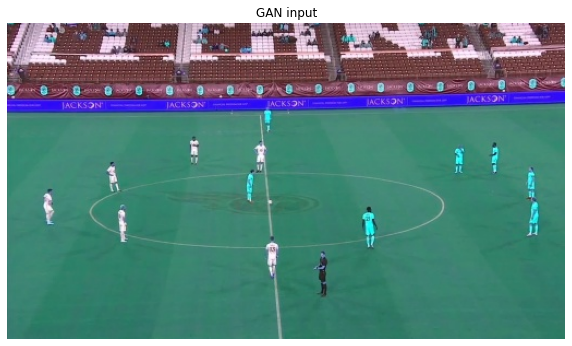

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/GanInput.jpg'), 'GAN input')

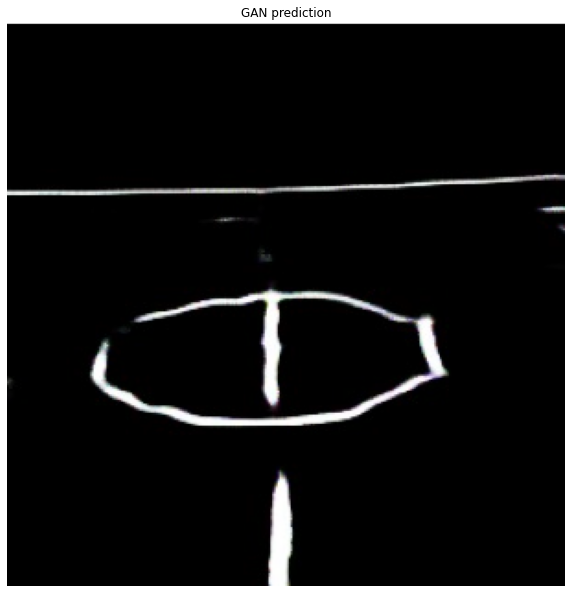

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/GanPrediction.jpg'), 'GAN prediction')

Now, we have the gan, we are able to generate a new 2D image given a real frame.

Using again our dataset, we will now generate a big database from these images by applying the following transformations:
- Pan: We simulate pan by rotating the quadrilateral (q0q1q2q3) around the point of convergence of lines (q0q3) and (q1q2) to obtain the modified quadrilateral. Values used for pan were [-0.1, 0.1, 0.15, -0.15, -0.18, 0.18].
- Tilt: We simulate zoom by applying a scaling matrix to the homogenous coordinates of q0,q1,q2andq3. Values used for tilting were [-0.05, 0.05, 0.02, -0.02, -0.035, 0.035].
- Zoom: We simulate tilt by moving the points q0,q1,q2,q3 up/down by a constant distance along their respective lines (q0q3) and (q1q2). Values used for zooming were [0.95, 1.1, 1.2, 1.15, 0.9, 0.85].
This Database will be used in order to match the prediction of the GAN using HOG descriptor and find the best matching to the prediction actual image.

For Database generation we used warpandgen.py and for the best matching images the knn_fullprocess.py from [Hawk eye](https://github.com/nihal111/hawk_eye).

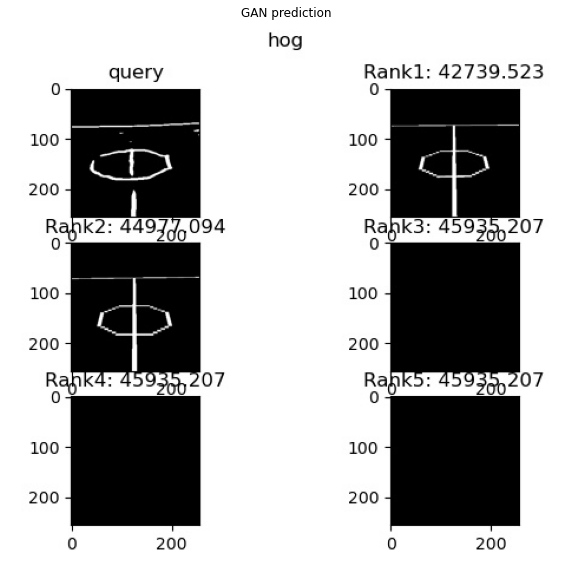

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/Top5MatchingToGANOutput.png'), 'GAN prediction')

Now we have, the best matching image, we will plot the actual one into the 2D court. For this we used the CameraToTop.py

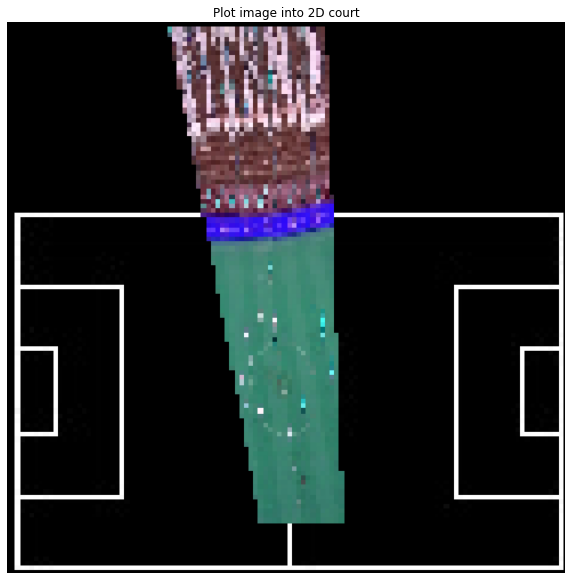

In [ ]:
plot_image(cv2.imread('/content/SportAnalytics/Images/Results.png'), 'Plot image into 2D court')

##7 References

[1] [Sports Video Analysis using Machine Learning](https://www.linkedin.com/pulse/sports-video-analysis-using-machine-learning-stephan-janssen/)

[2] [Automatic Birds Eye View Registration of Sports Videos](https://nihal111.github.io/hawk_eye/)

[3] [YOLO digit detector](https://github.com/penny4860/Yolo-digit-detector)

[4] [Pix2Pix Pytorch](https://github.com/mrzhu-cool/pix2pix-pytorch)

[5] [Finding the dominant colors of an image](https://www.timpoulsen.com/2018/finding-the-dominant-colors-of-an-image.html)